In [18]:
import math
import numpy as np
import healpy as hp
import sys
import time

#3rd party modules
from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c
from astropy.io import fits
import getpass
from halotools.mock_observables import angular_tpcf
from scipy import integrate, interpolate
from scipy.stats import poisson
    
#Plot
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm, ticker, patches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse
## default setting
fig_width_pt = 900                     # Suited for LaTeX
inches_per_pt = 1.0/72.27              # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0   # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt # width in inches
fig_height = fig_width*golden_mean     # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.linewidth' : 2,
          'legend.fontsize': 14,
          'text.usetex'    : False,
          'figure.figsize' : fig_size}
dotseq = [2, 2]
dashdotseq = [7, 4, 3, 4]
plt.rcParams.update(params)

def log_10_product(x, pos):
    return '%1g' % (x)

formatter = ticker.FuncFormatter(log_10_product)
%config InlineBackend.figure_format = 'retina'

In [19]:
#Reading in the data

halos = fits.open('MICE2lightcone_halos_Mh13.5above_z0.35.fits')[1].data
print(halos.shape[0])
print(halos['z_cgal_v'])

gws = fits.open('MICE2lightcone_gwhalos_Mh12.5_z0.35.fits')[1].data
print(gws.shape[0])

rand_halos = np.load('MICE2lightcone_rand_halos_Mh13.5above_z0.35.npy')

7804244
[0.16337 0.30527 0.33748 ... 0.16761 0.1341  0.12919]
18041259


In [20]:
#compute luminosity distance versus z_red relation
cp = FlatLambdaCDM(H0=70, Om0=0.25)

numz = 501
a_zred = np.array([iz/numz for iz in range(501)])
a_dL = cp.luminosity_distance(a_zred).value

func_zred_to_dL = interpolate.InterpolatedUnivariateSpline(a_zred, a_dL)
func_dL_to_zred = interpolate.InterpolatedUnivariateSpline(a_dL, a_zred)

In [21]:
zlow = func_dL_to_zred(200)#originally at 1600
zhigh = func_dL_to_zred(400)

#selected in redshift space
mask = (gws['z_cgal_v']>=zlow) & (gws['z_cgal_v']<zhigh)
print('gw {0:4.3f} <= z_red < {1:4.3f}'.format(zlow, zhigh))
print('mean gw z_red = {0:4.3f}'.format(np.mean(gws[mask]['z_cgal_v'])))

tmp_idx = np.random.randint(1, gws[mask].shape[0], size=5100)
tmp_gws = gws[mask][tmp_idx]
print('# of selected gws = {0}'.format(tmp_gws.shape[0]))
#print('# of selected halos = {0}'.format(tmp_halos.shape[0]))

gw 0.045 <= z_red < 0.087
mean gw z_red = 0.080
# of selected gws = 5100


NameError: name 'w_theta12' is not defined

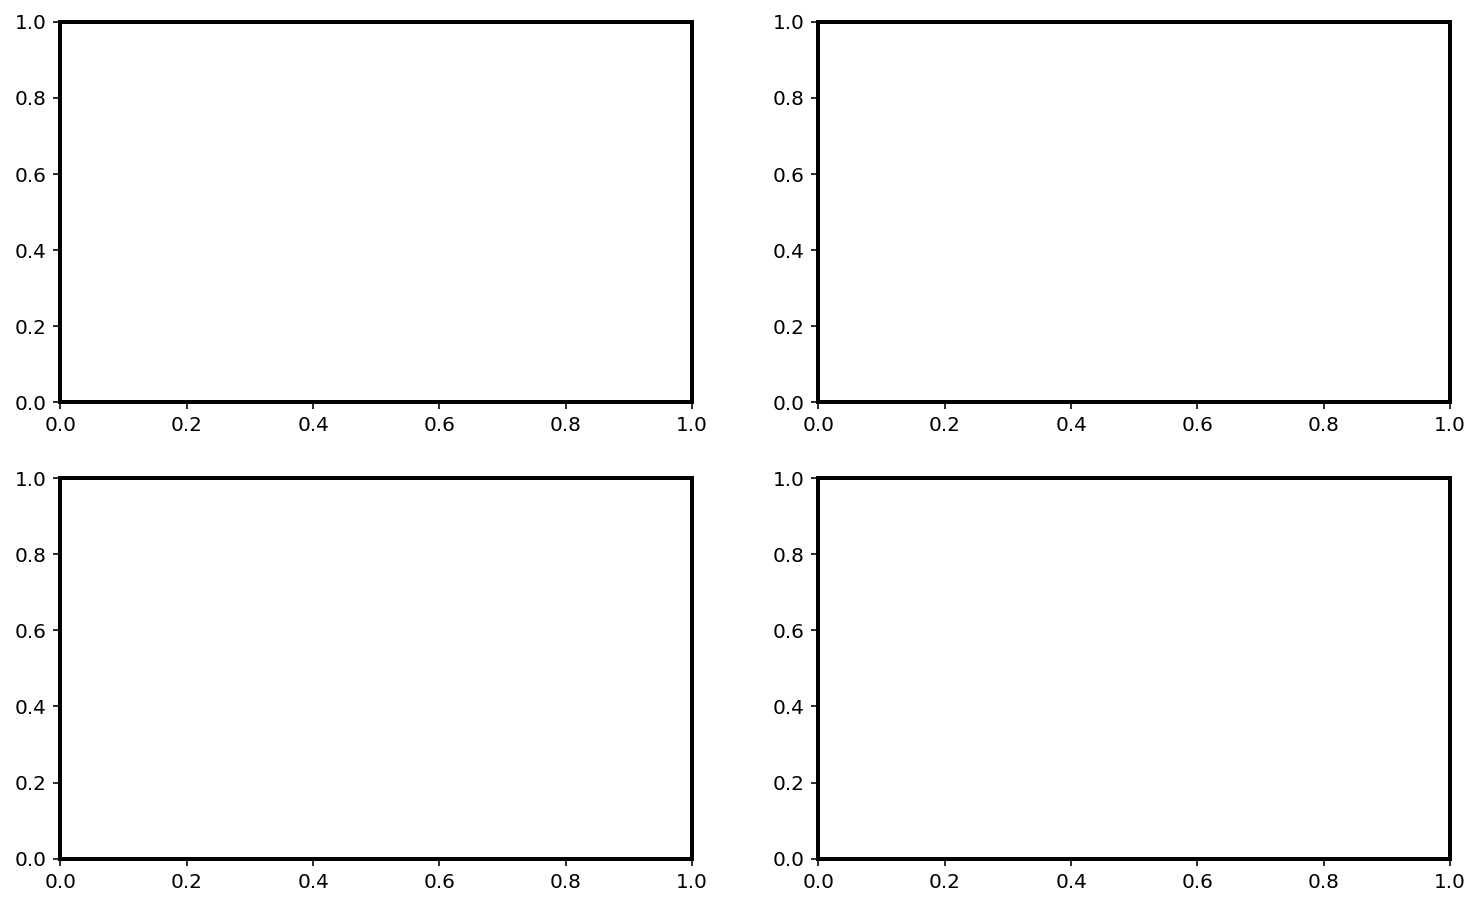

In [22]:
#creating the theta bins for TPCF
theta_bins = np.arange(.001,.031,.001)
cen_theta_bins = (theta_bins[:-1]+theta_bins[1:])/2.0
#print("The theta bins:", theta_bins)


test_statistic = np.mean

#creating the randoms for the TPCF
def make_random_radec(num_rand):
    dtype_rand = np.dtype([('ra_gal', float), ('dec_gal', float)])
    randoms = np.zeros(shape=(num_rand), dtype=dtype_rand)

    #next assign (ra,dec)
    RA_min, RA_max = 0, np.pi/2 #[radian]pi/2 originally
    DEC_min, DEC_max = 0, np.pi/2 #[radian]pi/2 originally

    ran1_min = RA_min/2/np.pi + 0.5
    ran1_max = RA_max/2/np.pi + 0.5
    ran2_min = 0.5*np.sin(np.pi/2 - DEC_min) + 0.5
    ran2_max = 0.5*np.sin(np.pi/2 - DEC_max) + 0.5

    ran1, ran2 = np.random.random(2*num_rand).reshape(2, -1)
    ran_RA  = (ran1_max - ran1_min)*ran1 + ran1_min
    ran_DEC = (ran2_max - ran2_min)*ran2 + ran2_min #this is actually theta = pi/2 - DEC

    randoms['ra_gal'][:] = 2*np.pi*(ran_RA - 0.5)*180/np.pi #[degree]
    randoms['dec_gal'][:] = np.arcsin(2*(ran_DEC-0.5))*180/np.pi #[degree]
    #print(ran_RA)
    return randoms

rand_gws = make_random_radec(5000000)
rand_halos = make_random_radec(5000000)
rand_RA2 = rand_gws['ra_gal'][:]
rand_DEC2 = -rand_gws['dec_gal'][:] + 90
rand_N2 = rand_DEC2.shape[0]
rand_ang_coords = np.vstack((rand_RA2,rand_DEC2)).T

tmp_gws = tmp_gws[(tmp_gws['ra_gal']>0) & (tmp_gws['dec_gal']>0)]
RA2 = tmp_gws['ra_gal'][:]
DEC2 = -tmp_gws['dec_gal'][:] + 90
N2 = DEC2.shape[0]

t_s = time.time()
angular_coords2 = np.vstack((RA2,DEC2)).T

mean_y1 = []
mean_x1 = []

fig, axis = plt.subplots(2,2)

for redshift in np.arange(0.07,0.37,0.015):
    halos_mask = (halos['z_cgal_v']>=(redshift-.015)) & (halos['z_cgal_v']<redshift)
    tmp_halos = halos[halos_mask]
    tmp_halos = tmp_halos[(tmp_halos['ra_gal']>0) & (tmp_halos['dec_gal']>0)]
    RA1 = tmp_halos['ra_gal'][:]
    DEC1 = -tmp_halos['dec_gal'][:] + 90
    angular_coords1 = np.vstack((RA1,DEC1)).T

     
    
    ###################### VERY COOL AND GOOD TPCF ####################
    #w_theta12 = angular_tpcf(angular_coords1, theta_bins, sample2=angular_coords2, randoms=rand_ang_coords, num_threads='max', do_auto=False, do_cross=True)
    
    ###################### WEIGHTED AVERAGE ###########################
    for n in range(29):
        sum_x = 0
        sum_y = 0
        sum_x += w_theta12[n]
        sum_y += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
        
    mean_x = sum_x/.03
    mean_y = sum_y/(2*np.pi*theta_bins[29])
    #estimate, bias, stderr, conf_interval = jackknife_stats(w_theta12, test_statistic, 0.95)
    mean_x1.append(mean_x)
    mean_y1.append(mean_y)
    np.vstack(mean_x1)
    np.vstack(mean_y1)
    
    
    ###################### PLOT EVERYTHING ############################
    axis[0,0].plot(cen_theta_bins,w_theta12,'-', color='green',
         label = r'cross_corr')
    axis[0,0].set_ylabel(r'$w_{\theta}$', fontsize=20)
    axis[0,0].set_xlabel(r'$\theta$  $[{\rm degrees}]$')
    axis[0,0].set_title('Angular correlation function')

axis[0,1].plot(np.arange(0.07,0.37,0.015),mean_x1)
axis[0,1].set_title(r'mean $w_{\theta}$')
axis[0,1].set_xlabel('z')
axis[1,1].plot(np.arange(0.07,0.37,0.015),mean_y1)
axis[1,1].set_title(r'mean $\theta$')
axis[0,1].set_xlabel('z')
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))

In [ ]:
#creating the jackknife estimator
#sum_y += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
#mean_y = sum_y/(2*np.pi*theta_bins[29])

#may be able to use the jackknife resampling from astropy

N = 90                     #number of sub spaces
Variance = sigma**2
#do the angular_tpcf somewhere out here for each pixel

def find_mean(i):
    theta_1 = pixels[i]
    theta_1_rest = resampling[i]
    theta_2 = pixels[i+1]
    theta_2_rest = resampling[i+1]
    for n in range(29):
        sum_y = 0
        sum_y += w_theta12[n]*(2*np.pi*theta_bins[n]*(theta_bins[n+1]-theta_bins[n]))
    mean_y = sum_y/(2*np.pi*theta_bins[29])
    
    return theta_1_mean, theta_2_mean


def find_sigma():
    theta_1 = pixels[i]
    theta_2 = pixels[i+1]
    sigma = 1/(N-1) * sigma_sum
    sigma_sum = (theta_1 - theta_1_mean)*(theta_2 - theta_2_mean)
    
    
    return sigma


In [32]:
theta_bins2 = [0, 0.01658065, 0.0331613]
cen_theta_bins2 = (theta_bins[:-1]+theta_bins[1:])/2.0

t_s = time.time()

nside = 32
halo_coords = np.column_stack((RA1,DEC1))
pixels_halo = hp.ang2pix(nside,np.radians(RA1),np.radians(DEC1))
pixels_gws = hp.ang2pix(nside,np.radians(RA2),np.radians(DEC2))
pixels_rands = hp.ang2pix(nside,np.radians(rand_RA2),np.radians(rand_DEC2))
m = np.zeros(hp.nside2npix(nside))


if (np.max(pixels_halo) < np.max(pixels_gws)):
    pixel_count = np.max(pixels_gws)
else:
    pixel_count = np.max(pixels_halos)
#
a = 0

pixelated_halos = []
pixelated_gws = []
pixelated_rands = []

print(hp.max_pixrad(nside, degrees = True))
w_theta12_pixels = []
for i in range(pixel_count):                    #range(pixel_count):
    x = np.where(pixels_halo == i)
    y = np.where(pixels_gws == i)
    z = np.where(pixels_rands == i)
    if np.size(x)>0:
        pixelated_halos = np.append(pixelated_halos,x,i)
    elif np.size(x)==0:
        pixelated_halos = np.append(pixelated_halos,0,i)
    if np.size(y)>0:
        pixelated_gws = np.append(pixelated_gws,y,i)
    elif np.size(y)==0:
        pixelated_gws = np.append(pixelated_gws,0,i)
    if np.size(z)>0:
        pixelated_rands = np.append(pixelated_halos,z,i)
    elif np.size(z)==0:
        pixelated_rands = np.append(pixelated_halos,0,i)
    
    pixelated_gws.append(y)
    pixelated_rands.append(z)
    

    
    if np.size(x) > 0 and np.size(y) > 0 and np.size(z) > 1:
        #calculate wtheta12 here
        pixelated_RA1 = RA1[x]
        pixelated_DEC1 = DEC1[x]
        pixelated_angular_coords1 = np.column_stack((pixelated_RA1,pixelated_DEC1))            #angular coords of each galaxy per pixel
        pixelated_RA2 = RA2[y]
        pixelated_DEC2 = DEC2[y]
        pixelated_angular_coords2 = np.column_stack((pixelated_RA2,pixelated_DEC2))            #angular coords of each gws per pixel
        pixelated_rand_RA2 = rand_RA2[z]
        pixelated_rand_DEC2 = rand_DEC2[z]
        pixelated_rand_coords = np.column_stack((pixelated_rand_RA2,pixelated_rand_DEC2))      #angular coords of each random per pixel
        #w_theta12_pixels.append(angular_tpcf(pixelated_angular_coords1, theta_bins2, sample2=pixelated_angular_coords2, randoms=pixelated_rand_coords, num_threads='max', do_auto=False, do_cross=True))
        a+=1
t_tmp = time.time() - t_s
print('computation took {0} seconds'.format(t_tmp))
#print((w_theta12_pixels))
#print(pixelated_halos)

1.902601860011511


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [31]:
pixel_exlude=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 64, 97, 129, 162, 194, 227, 259, 292, 324, 357, 389, 422, 454, 487, 519, 552, 584, 617, 649, 682, 714, 747, 779, 812, 844, 877, 909, 942, 974, 1007, 1039]
print(np.size(pixel_exlude))


pixelated_halos[pixel_exclude],pixelated_gws[pixel_exclude],pixelated_rands[pixel_exclude] == 0

resamp_pix_halo = jackknife_resampling(pixelated_halos)
resamp_pix_gws = jackknife_resampling(pixelated_gws)
resamp_pix_rand = jackknife_resampling(pixelated_rands)

for i in np.size(resamp_pix_halo):
    sum += w_theta(pixelated_halos[i]) - mean(w_theta(resamp_pix_halo, resamp_pix_halos, resamp_pix_rands, original theta bin))

64
(array([ 865, 1198, 1306]),)


TypeError: 'list' object is not callable